In [867]:
import matplotlib.pyplot as plt
import numpy as np

In [868]:
from enum import Enum

class Action(Enum):
    DEFECT = 0
    LEAVE = 0
    COOPERATE = 1
    STAY = 1

class State(Enum):
    # the agent is in the partner selection stage whose partner defected in their last prisoners dilemma game
    PARTNER_SELECTION_PARTNER_DEFECTED = 0
    PS_D = 0
    # the agent is in the partner selection stage whose partner cooperated in their last prisoners dilemma game
    PARTNER_SELECTION_PARTNER_COOPERATED = 1
    PS_C = 1
    # the agent is in the prisoner's dilemma stage whose partner defected in their last prisoners dilemma game
    PRISONERS_DILEMMA_PARTNER_DEFECTED = 2
    PD_D = 2
    # the agent is in the prisoner's dilemma stage whose partner defected in their last prisoners dilemma game
    PRISONERS_DILEMMA_PARTNER_COOPERATED = 3
    PD_C = 3

In [869]:
# returns the probabilities of selection actions given the current state 
def boltzmann_exploration(q_table, state: State, temperature: float):
    exp = np.exp((q_table[state.value, :] - np.max(q_table[state.value, :])) / temperature)
    return exp / np.sum(exp)

In [870]:
# returns the rewards of two agents in the prisoner's dilemma game
def prisoners_dilemma(a_i: Action, a_j: Action) -> tuple[float, float]:
    reward_table = np.array([[(1, 1), (5, 0)], [(0, 5), (3, 3)]])
    return reward_table[a_i.value, a_j.value]

In [871]:
# runs the Q-Learning algorithm on the provided qtable
# NOTE: alpha is the learning rate and gamma is the discount rate
def q_learning(qtable, state: State, action: Action, 
               reward: float, new_state: State, alpha: float, gamma: float) -> None:
    qtable[state.value, action.value] = (1.0 - alpha) * qtable[state.value, action.value] + \
        alpha * (reward + gamma * np.max(qtable[new_state.value, :]))

In [872]:
class Agent:
    def __init__(self, learning_rate: float, temperature: float, discount_rate: float, 
                 last_action: Action = None, qtable = None):
        self.a = learning_rate
        self.t = temperature
        self.g = discount_rate
        self.last_action = np.random.choice([Action.DEFECT, Action.COOPERATE], 1) if last_action == None else last_action
        self.qtable = np.zeros((4, 2)) if qtable == None else qtable
        
    # returns an action given the current state
    def get_action(self, state: State) -> Action:
        temp = boltzmann_exploration(self.qtable, state, self.t)
        return np.random.choice([Action.DEFECT, Action.COOPERATE], p=temp)

    # trains using trajectories from each round
    def train(self, trajectories, debug=False):
        for trajectory in trajectories:
            # partner selection training
            q_learning(self.qtable, trajectory[0], trajectory[1], 0, trajectory[2], self.a, self.g)
            if debug:
                print(trajectory)
                print(self.qtable)
                print()
            # prisoner's dilemma training
            q_learning(self.qtable, trajectory[2], trajectory[3], trajectory[5], trajectory[4], self.a, self.g)
            if debug:
                print(trajectory)
                print(self.qtable)
                print()
        # decrease temperature
        # self.t *= 0.01
        

In [873]:
def sdoo(population: int, rounds: int, episodes: int, learning_rate: float, temperature: float, discount_rate: float):
    recorded_outcomes = {
        (Action.DEFECT, Action.DEFECT): [0 for _ in range(episodes)],
        (Action.DEFECT, Action.COOPERATE): [0 for _ in range(episodes)],
        (Action.COOPERATE, Action.DEFECT): [0 for _ in range(episodes)],
        (Action.COOPERATE, Action.COOPERATE): [0 for _ in range(episodes)],
    }

    total_reward = [0 for _ in range(episodes)]

    np.random.seed(0)

    agents = [Agent(learning_rate, temperature, discount_rate) for _ in range(population)]
    unpaired = list(range(population))

    # Pair Agents
    pairs: tuple[int, int] = []
    while unpaired:
        i = unpaired.pop(np.random.randint(len(unpaired)))
        j = unpaired.pop(np.random.randint(len(unpaired)))
        pairs.append((i, j))

    
    for episode in range(episodes):

        trajectories = [[] for _ in range(population)]
        for round in range(rounds):

            # Partner Selection
            temp_pairs = []
            for (i, j) in pairs:
                s_i = State.PS_C if agents[j].last_action == Action.COOPERATE else State.PS_D
                s_j = State.PS_C if agents[i].last_action == Action.COOPERATE else State.PS_D
                a_i = agents[i].get_action(s_i)
                a_j = agents[j].get_action(s_j)

                if a_i == Action.LEAVE or a_j == Action.LEAVE:
                    unpaired.append(i)
                    unpaired.append(j)
                else:
                    temp_pairs.append((i, j))

                trajectories[i].append((s_i, a_i))
                trajectories[j].append((s_j, a_j))

            # Pair Agents
            pairs = temp_pairs
            while unpaired:
                i = unpaired.pop(np.random.randint(len(unpaired)))
                j = unpaired.pop(np.random.randint(len(unpaired)))
                pairs.append((i, j))

            # Prisoner's Dilemma
            for (i, j) in pairs:
                s_i = State.PD_C if agents[j].last_action == Action.COOPERATE else State.PD_D
                s_j = State.PD_C if agents[i].last_action == Action.COOPERATE else State.PD_D
                a_i = agents[i].get_action(s_i)
                a_j = agents[j].get_action(s_j)
                r_i, r_j = prisoners_dilemma(a_i, a_j)
                total_reward[episode] += r_i + r_j
                ns_i = State.PS_C if a_j == Action.COOPERATE else State.PS_D
                ns_j = State.PS_C if a_i == Action.COOPERATE else State.PS_D
                recorded_outcomes[(a_i, a_j)][episode] += 1
                agents[i].last_action = a_i
                agents[j].last_action = a_j

                t = trajectories[i][round]
                trajectories[i][round] = (t[0], t[1], s_i, a_i, ns_i, r_i)
                t = trajectories[j][round]
                trajectories[j][round] = (t[0], t[1], s_j, a_j, ns_j, r_j)

        # print()
        for idx, agent in enumerate(agents):
            agent.train(trajectories[idx])
            # agent.train(trajectories[idx], debug=(idx == 0))
        
        

    # Plot Prisoner's Dilemma Outcomes
    plt.plot(recorded_outcomes[(Action.DEFECT, Action.DEFECT)], linewidth=1)
    plt.plot(recorded_outcomes[(Action.DEFECT, Action.COOPERATE)], linewidth=1)
    plt.plot(recorded_outcomes[(Action.COOPERATE, Action.DEFECT)], linewidth=1)
    plt.plot(recorded_outcomes[(Action.COOPERATE, Action.COOPERATE)], linewidth=1)
    
    plt.xlabel('Episode')
    plt.ylabel('Number of Outcomes')
    plt.ylim(0, population * rounds / 2)
    plt.legend(["(D, D)", "(D, C)", "(C, D)", "(C, C)", "Total Reward"])

    plt.show()


    # Plot Total Rewards
    plt.plot(total_reward, linewidth=3)

    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.ylim(0, 6 * population * rounds / 2)
    
    plt.show()


    # Plot Agent Strategies
    ps_strategies = [
        ("Always-Stay", np.array([[0, 1], [0, 1]]), 'lightcoral'),
        ("Out-for-Tat", np.array([[1, 0], [0, 1]]), 'lightsteelblue'),
        ("Reverse-OFT", np.array([[0, 1], [1, 0]]), 'lightgreen'),
        ("Always-Switch", np.array([[1, 0], [1, 0]]), 'tan'),
    ]
    pd_strategies = [
        ("Always-Cooperate", np.array([[0, 1], [0, 1]]), 'red'),
        ("Tit-for-Tat", np.array([[1, 0], [0, 1]]), 'blue'),
        ("Reverse-TFT", np.array([[0, 1], [1, 0]]), 'green'),
        ("Always-Defect", np.array([[1, 0], [1, 0]]), 'yellow'),
    ]
    
    num_strategies_ps = [0 for _ in ps_strategies]
    num_strategies_pd = [0 for _ in pd_strategies]

    strategy_combinations = np.zeros((len(ps_strategies), len(pd_strategies)))

    # Determine Agent Strategies
    for idx, agent in enumerate(agents):
        strategy_ps = 0
        strategy_ps_angle = 90
        for ps_idx, strategy in enumerate(ps_strategies):
            agent_norm = np.linalg.norm(agent.qtable[0:2, :])
            strategy_norm = np.linalg.norm(strategy[1])
            prod = np.sum(agent.qtable[0:2, :] * strategy[1])
            angle = np.rad2deg(np.arccos(prod / (agent_norm * strategy_norm)))
            if angle < strategy_ps_angle:
                strategy_ps = ps_idx
                strategy_ps_angle = angle

        strategy_pd = 0
        strategy_pd_angle = 90
        for pd_idx, strategy in enumerate(pd_strategies):
            agent_norm = np.linalg.norm(agent.qtable[2:4, :])
            strategy_norm = np.linalg.norm(strategy[1])
            prod = np.sum(agent.qtable[2:4, :] * strategy[1])
            angle = np.rad2deg(np.arccos(prod / (agent_norm * strategy_norm)))
            if angle < strategy_pd_angle:
                strategy_pd = pd_idx
                strategy_pd_angle = angle
        
        num_strategies_ps[strategy_ps] += 1
        num_strategies_pd[strategy_pd] += 1
        strategy_combinations[strategy_ps, strategy_pd] += 1
        
        print("Agent %i) PS-Strategy: %s (%fdeg), PD-Strategy: %s (%fdeg)" % 
            (idx, ps_strategies[strategy_ps][0], strategy_ps_angle, pd_strategies[strategy_pd][0], strategy_pd_angle))
        print(agent.qtable)

    plt.subplot(211)
    ps_colors = [c[2] for c in ps_strategies]
    plt.bar([s[0] for s in ps_strategies], num_strategies_ps, color=ps_colors)
    plt.title('PS-Strategies')
    plt.xlabel('Strategy')
    plt.ylabel('Number of Agents')
    plt.ylim(0, population)
    plt.show()

    plt.subplot(212)
    pd_colors = [c[2] for c in pd_strategies]
    plt.bar([s[0] for s in pd_strategies], num_strategies_pd, color=pd_colors)
    plt.title('PD-Strategies')
    plt.xlabel('Strategy')
    plt.ylabel('Number of Agents')
    plt.ylim(0, population)
    plt.show()

    combination_indices = [i for i in range(len(strategy_combinations.ravel()))]
    ps_combination_colors = np.repeat([c[2] for c in ps_strategies], 4)
    pd_combination_colors = np.tile([c[2] for c in pd_strategies], 4)
    plt.bar(combination_indices, strategy_combinations.ravel() / 2, color=ps_combination_colors)
    plt.bar(combination_indices, strategy_combinations.ravel(), bottom=(strategy_combinations.ravel() / 2), color=pd_combination_colors)
    plt.title('Strategy Combinations')
    plt.xlabel('Strategy')
    plt.ylabel('Number of Agents')
    plt.ylim(0, population)
    plt.legend(
        [plt.Rectangle((0, 0), 1, 1, color=c[2]) for c in (ps_strategies + pd_strategies)],
        [c[0] for c in (ps_strategies + pd_strategies)],
        loc='upper center',
        bbox_to_anchor=(0.5, 1.35),
        ncol=4,
    )
    plt.show()


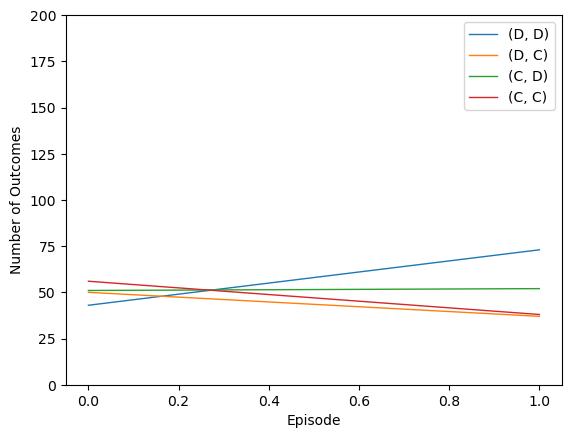

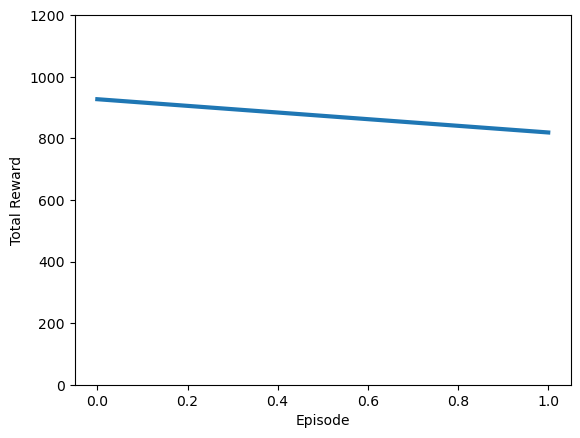

Agent 0) PS-Strategy: Always-Switch (34.336084deg), PD-Strategy: Always-Defect (30.883963deg)
[[0.49258686 0.400031  ]
 [0.44549175 0.21015628]
 [2.35220932 0.71794512]
 [0.81905535 0.32881391]]
Agent 1) PS-Strategy: Reverse-OFT (43.998054deg), PD-Strategy: Always-Defect (17.785375deg)
[[0.33283675 0.35286381]
 [0.20467455 0.15219017]
 [1.11447263 0.45653764]
 [1.27144441 0.26859469]]
Agent 2) PS-Strategy: Always-Stay (32.963518deg), PD-Strategy: Always-Defect (37.415956deg)
[[0.19220827 0.34543176]
 [0.21931247 0.29521142]
 [0.7907324  0.76133318]
 [1.27045816 0.74058528]]
Agent 3) PS-Strategy: Reverse-OFT (37.949255deg), PD-Strategy: Reverse-TFT (36.933852deg)
[[0.16902487 0.29201507]
 [0.41911517 0.34224862]
 [0.95430696 1.13929471]
 [1.44940239 0.96682658]]
Agent 4) PS-Strategy: Always-Stay (36.978178deg), PD-Strategy: Always-Defect (38.841362deg)
[[0.28977789 0.3945685 ]
 [0.21548467 0.29616153]
 [1.11295656 0.9197571 ]
 [0.799607   0.53923668]]
Agent 5) PS-Strategy: Out-for-Tat (

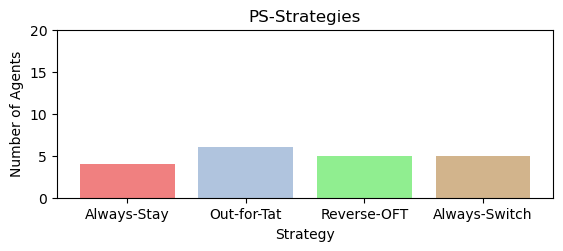

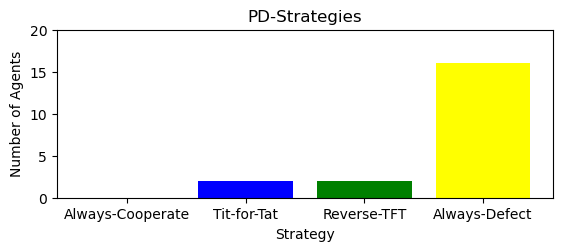

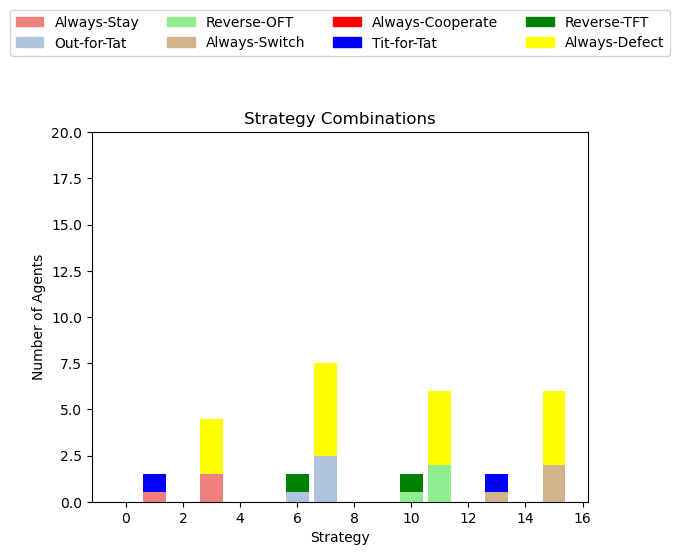

In [874]:
sdoo(20, 20, 2, 0.05, 1, 1)